# Disciplina de Aprendizado de Máquina não supervisionado

## Aula 02

### Parte I: Revisão e aprofundamento de métodos de inspeção visual



In [116]:
# instalação de bibiotecas necessárias
!pip install kneed joypy scikit-learn-extra fuzzy-c-means

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [117]:
# uso das bibliotecas necessárias
import matplotlib.pyplot as plt
import sklearn.datasets
import seaborn as sns
import numpy as np
import pandas as pd
import joypy
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib import cm

Revisitando o *dataset* `iris`, que tem 4 dimensões e 3 subtipos de flores (atributo `target`) com **algumas possibilidades de análise exploratória**.

Vamos construir tabelas e também gráficos que nos auxiliem na compreensão dos dados.

In [118]:
# Carrega os dados e os apresenta em forma de tabela (dataset pandas)
data, target = sklearn.datasets.load_iris(return_X_y=True, as_frame=True)
data["target"] = target
dados = data.iloc[:, 0:4] # seleciona só as 4 primeiras colunas
dimensoes = dados.values  # dados vistos como arrays (para usar no kmeans)
data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [119]:
dados.describe() # informações estatísticas básicas

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


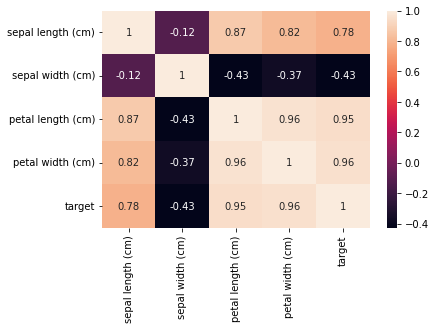

In [120]:
# Heatmap de correlação de valores por pares de dimensões
# Para mais informações sobre heatmaps, ver: https://chartio.com/learn/charts/heatmap-complete-guide/
correl=data.corr()
sns.heatmap(correl,annot=True)

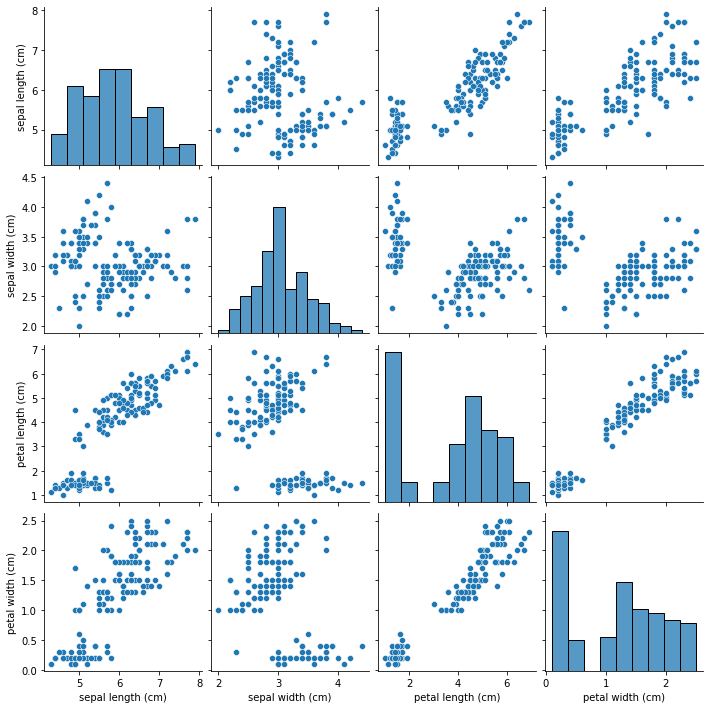

In [121]:
# análise pareada
# Detalhes e opções de pairplot em: https://seaborn.pydata.org/generated/seaborn.pairplot.html
sns.pairplot(dados)

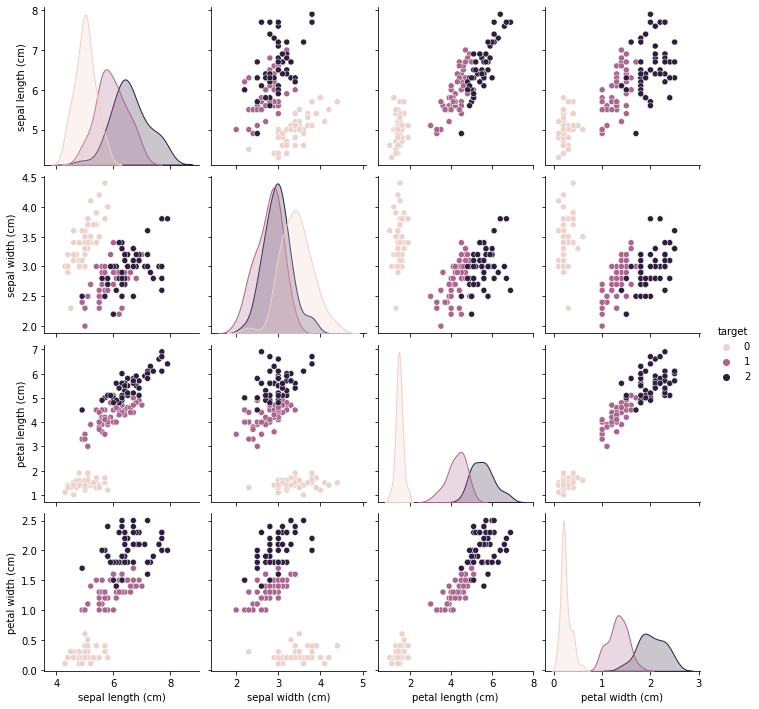

In [122]:
# análise pareada com semântica (por subtipo de flor)
sns.pairplot(data, hue="target")

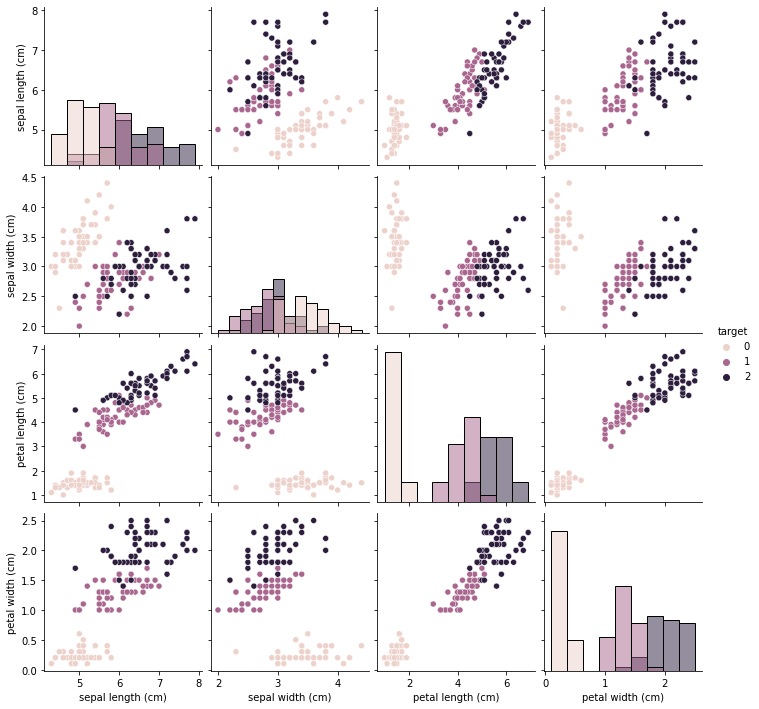

In [123]:
# similar, mas com histograma empilhado
sns.pairplot(data, hue="target", diag_kind="hist")

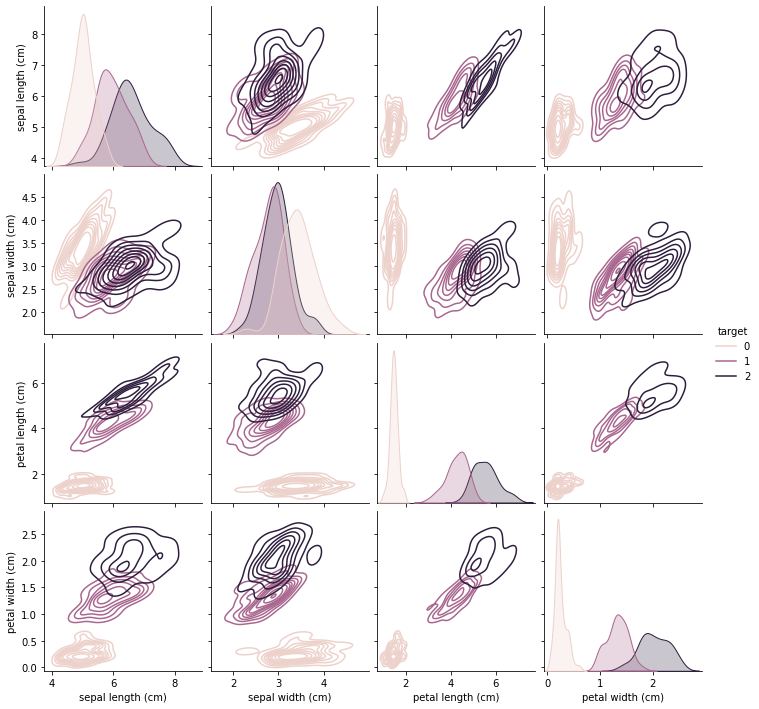

In [124]:
# alternativa que ilustra densidades com base em estimativa de kernel gaussiano
# Detalhes sobre o funcionamento de kde (gaussiano ou não): https://en.wikipedia.org/wiki/Kernel_density_estimation
sns.pairplot(data, hue="target", kind="kde")

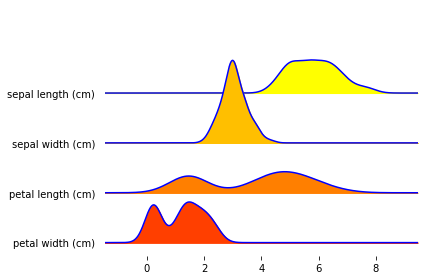

In [125]:
# Joyplot que apresenta a densidade (estimativa por kernel gaussiano) dos valores por dimensão
# Exemplos e opções em: https://deepnote.com/@deepnote/Joyplot-Introduction-4666e1a3-3249-442e-9a94-2bbcc5cb1b1d 
fig, axes = joypy.joyplot(dados, linecolor="blue", colormap=cm.autumn_r)

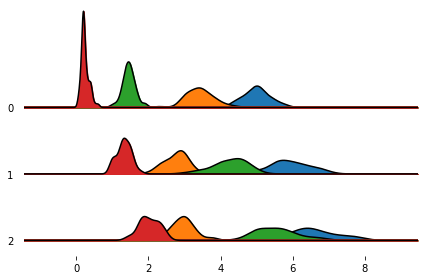

In [126]:
# densidade de dimensão por subtipo de flor (target)
fig, axes = joypy.joyplot(data, by="target")

---
### Parte II: Revisão e aprofundamento de métodos avaliação intrínseca (interna)

Vamos avaliar se o *k-means* consegue identificar um conjunto de *clusters* semelhante à quantidade de subtipos de flores? 

Lembre-se que temos `3` subtipos de flores no **dataset** `iris`.

Vamos executar um *script* que avalia o resultado da clusterização por `k-means` com `k` variando entre `1` e `10`. Como métricas, usaremos `SSE` e `Silhouette`. Usaremos o método do cotovelo (*elbow*) e também analisaremos os perfis de `Silhouette` de cada configuração de *cluster*. 

Ao final, já que temos informação sobre os subtipos originais de flores, vamos aplicar também algumas métricas de avaliação extrínseca (externa) a fim de verificar o quão próximo da "realidade" são os resultados da clusterização.

---

Lembre-se de que o **`SSE`** avalia a soma dos quadrados intra-clusters (*within-clusters sum-of-squares*) e ela deve ser a menor possivel (pressupondo que o espaço das dimensões é métrico euclidiano e que os *clusters* são isométricos, não possuíndo geometrias complicadas) para que um *cluster* tenha elementos o mais próximo o possível de seu centroide (afinal o `k-means` avalia a distância dos elementos de um *cluster* em relação aos seus centroides). 

Logo, quanto mais *clusters* tivermos, menores serão as diferenças entre eles, mas maiores serão as diferenças intra-clusters. Temos que achar um ponto de equilíbrio em termos de homegenidade de elementos dentro de grupos, ao mesmo tempo em que os grupos sejam diferentes uns dos outros. 

O **`Silhouette`** avalia simultaneamente a coesão (distância intra-cluster) e o acoplamento (distância entre clusters), variando entre `-1` e `1`. O valor ideal seria `1`, indicando que um elemento está em um *cluster* muito compacto e igualmente distante dos demais *clusters*. Valores próximos de `0` indicam que há alguma sobreposição de *clusters*. O pior valor é `-1`. 

---

In [127]:
# Cria 10 modelos (com k variando entre 1 e 10) e tenta identificar o melhor

scaler = StandardScaler()
scaled_features = scaler.fit_transform(dimensoes)

# Parâmeros dos modelos k-means utilizados
parametros_basicos_kmeans = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 0,
}

resultados = {} # Dicionário que armazena SSE, silhouette e número de iterações para cada 'k'

# executa o algoritmo para 'k' variando entre 1 e 10
# e armazena os resultados de SSE e Silhouette
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **parametros_basicos_kmeans)
    kmeans.fit(scaled_features)
    if k>1:   # silhouette não pode ser calculado quando só temos 1 cluster!
       silhouette = silhouette_score(scaled_features, kmeans.labels_)
    else:
       silhouette = 0.0
    resultados[k] = {"SSE": kmeans.inertia_, "Silhouette": silhouette, "Iterações": kmeans.n_iter_} 

# cria uma tabela (dataframe pantas) com os resultados
resultados = pd.DataFrame.from_dict(resultados)
resultados

,1,2,3,4,5,6,7,8,9,10
SSE,600.0,222.361705,139.820496,114.556844,91.555362,81.654407,71.033431,63.370596,55.887740,50.917059
Silhouette,0.0,0.581750,0.459948,0.415113,0.366366,0.343222,0.327694,0.341546,0.336063,0.330672
Iterações,2.0,5.000000,11.000000,8.000000,7.000000,7.000000,9.000000,5.000000,10.000000,6.000000


Vamos analisar o gráfico de `SSE` vs quantidade de *clusters*:

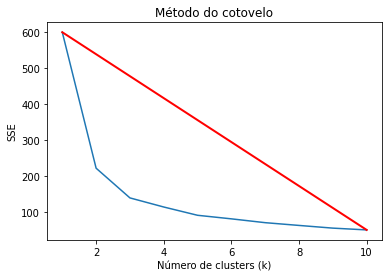

In [128]:
valores_sse = resultados.iloc[0].values # seleciona a primeira linha da tabela
plt.plot(range(1,11), valores_sse)
plt.plot([1,10], [valores_sse[0], valores_sse[9]], color='red', linestyle='-', linewidth=2) # baseline visual para cálculo do cotovelo 
plt.title("Método do cotovelo")
plt.xlabel("Número de clusters (k)")
plt.ylabel("SSE")
plt.show()

In [129]:
# O SSE mais adequado é o que tem maior distância entre o baseline e o valor de SSE 
kl = KneeLocator(range(1, 11), resultados.iloc[0].values, curve="convex", direction="decreasing")
print(f"Valor sugerido para 'k': {kl.elbow}")

Valor sugerido para 'k': 3


Vamos analisar de diferentes maneiras o coeficiente de `Silhouette` vs quantidade de *clusters*:

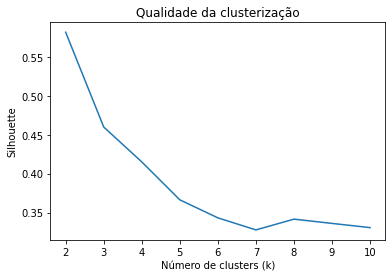

In [130]:
plt.plot(range(2,11), resultados.iloc[1].values[1:]) # não adianta iniciar com k=1 pq não tem esse valor (é zero)
plt.title("Qualidade da clusterização")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette")
plt.show()

Text(0.5, 0.98, 'Gráfico de Silhouette para os diferentes clusters')

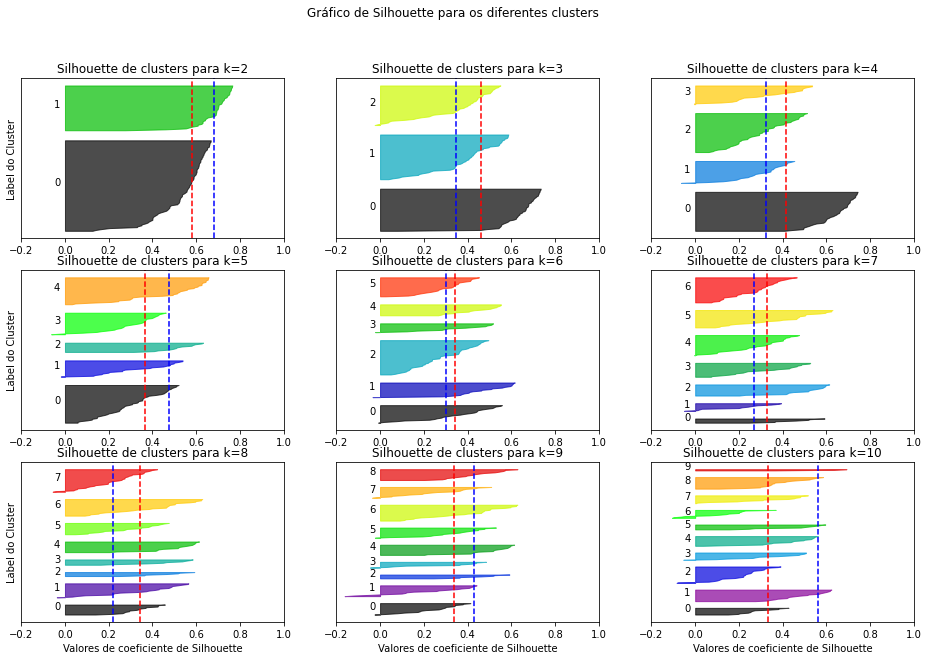

In [131]:
# Gráfico de Silhouette para os diferentes clusters
# Tarefa: melhorar o código para reaproveitar o que já foi calculado antes

fig, ax = plt.subplots(3,3, figsize=(16,10))  # 3 linhas por 3 colunas

lin = col = 0                                 # para gerenciar o posicionamento dos subgráficos
for k in range(2,11):                        
  ax[lin,col].set_xlim([-.2, 1])              # os valores de silhouette variam entre -1 e 1 (mas aqui estão entre -0.2 e 1)
  
  kmeans = KMeans(n_clusters=k, **parametros_basicos_kmeans) # recalcula clusters
  labels = kmeans.fit_predict(scaled_features)               # devolve etiquetas de clusters
  
  silhouette_values = silhouette_samples(scaled_features, labels) # calcula Silhouette para cada cluster
  
  lower_y = 10  
  for i in range(k):
    escore_silhouette_i = silhouette_values[labels == i]
    escore_silhouette_i.sort()

    size_cluster_i = escore_silhouette_i.shape[0]
    upper_y = lower_y + size_cluster_i

    cor = cm.nipy_spectral(float(i)/k)
    ax[lin,col].fill_betweenx(np.arange(lower_y, upper_y), 0, escore_silhouette_i, facecolor=cor, edgecolor=cor, alpha=0.7)
    ax[lin,col].text(-0.05, lower_y+0.5*size_cluster_i, str(i))
    lower_y = upper_y+10 

  ax[lin,col].set_yticks([])
  ax[lin,col].set_title(f"Silhouette de clusters para k={k}")  
  
  ax[lin,col].axvline(x=resultados[k]["Silhouette"], color="red", linestyle="--") # Valor de Silhouette
  ax[lin,col].axvline(np.mean(escore_silhouette_i), color="blue", linestyle="--") # Média dos Silhouettes por cluster

  col += 1                                                                        # calcula onde colocar o próximo subgráfico
  if col > 2:
    col = 0
    lin += 1

ax[2,0].set_xlabel("Valores de coeficiente de Silhouette")
ax[2,1].set_xlabel("Valores de coeficiente de Silhouette")
ax[2,2].set_xlabel("Valores de coeficiente de Silhouette")
ax[0,0].set_ylabel("Label do Cluster")
ax[1,0].set_ylabel("Label do Cluster")
ax[2,0].set_ylabel("Label do Cluster")

plt.suptitle("Gráfico de Silhouette para os diferentes clusters")  

Como `3` parece ser o melhor (e é a quantidade original de flores), vamos usá-lo:

In [132]:
kmeans = KMeans(n_clusters=3, **parametros_basicos_kmeans)
kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=3, random_state=0)

In [133]:
data['resultado']=kmeans.labels_
data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,resultado
0,5.1,3.5,1.4,0.2,0,0
1,4.9,3.0,1.4,0.2,0,0
2,4.7,3.2,1.3,0.2,0,0
3,4.6,3.1,1.5,0.2,0,0
4,5.0,3.6,1.4,0.2,0,0
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,2
146,6.3,2.5,5.0,1.9,2,1
147,6.5,3.0,5.2,2.0,2,2
148,6.2,3.4,5.4,2.3,2,2


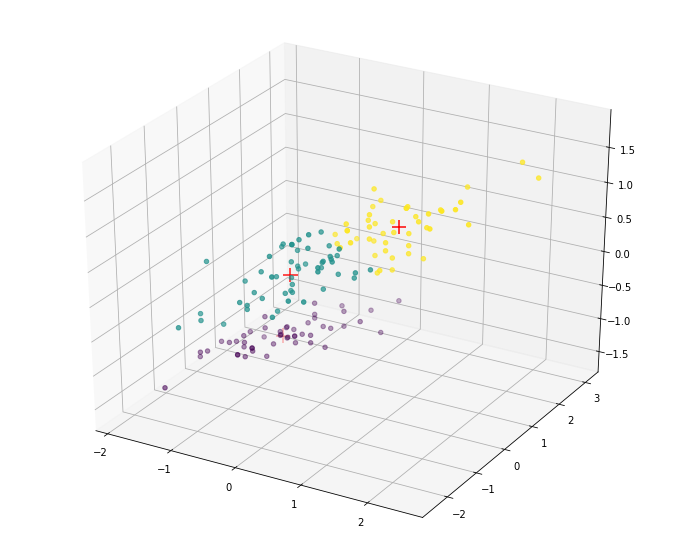

In [134]:
# Mostra os clusters encontrados em 3D (mas lembre-se que há 4 no total!)
# para mostrar todas, teremos que usar alguma técnica de redução de dimensionalidade 
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection='3d')

ax.scatter3D(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,2], c="red", marker="+", s=200)
ax.scatter3D(scaled_features[:,0], scaled_features[:,1], scaled_features[:,2],c=kmeans.labels_)

plt.show()

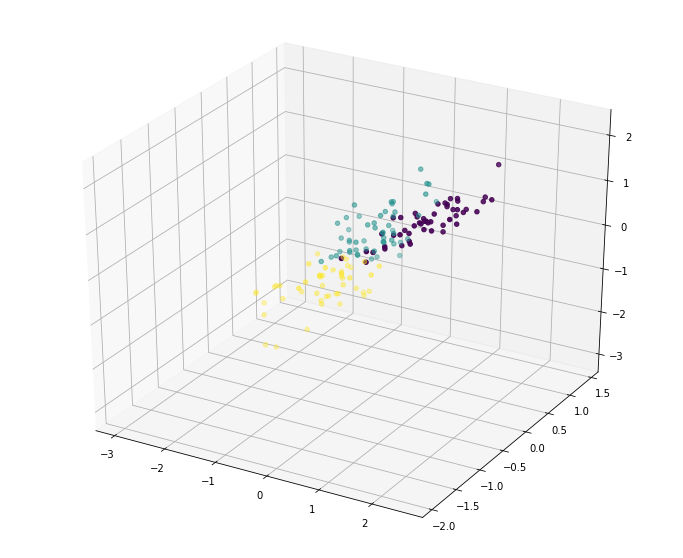

In [135]:
# Usa método de reescalonamento multidimensional (MDS) para combinar as 4 dimensões em 3
# que procura perservar as distâncias originais no espaço
# detalhes sobre o MDS em: https://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling
from sklearn.manifold import MDS

embedding = MDS(n_components=3)
transformed = embedding.fit_transform(dados)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(transformed[:,0], transformed[:,1], transformed[:,2],c=kmeans.labels_)
plt.show()

---
### Parte III: Métodos avaliação extrínseca (externa)


A avaliação extrínseca ou externa consiste em comparar os resultados com algum resultado esperado, previamente conhecido. Ela só é possível quando temos informações sobre a estrutura dos dados, eventualmente fugindo um pouco dos objetivos da clusterização (e é mais comum em aprendizado supervisionado). Mas é uma técnica utilizada quando estamos criando ou comparando algoritmos, considerando um *baseline* ou *ground truth*.

O seguinte artigo aplica essa abordagem:

[Wives, Leandro Krug; Loh, Stanley; Oliveira, José Palazzo Moreira de. A Comparative Study of Clustering versus Classification over Reuter's Collection; In: Proceedings of the 8th International Workshop on Pattern Recognition in Information Systems (in conjunction with ICEIS 2008). 12-13 June, Barcelona, Spain, 2008. pp. 231-236.](https://www.scitepress.org/Papers/2008/17362/17362.pdf)

---
Bem, vamos iniciar nossa análise com observações estatísticas (descritivas) básicas. Depois vamos utilizar acurácia, precisão e revocação. Também há outras possibilidades...

In [136]:
dados_por_tipo_flor = data.groupby('target')
filtro = dados_por_tipo_flor.describe().columns.get_level_values(1).isin(['mean', 'std', 'count'])
dados_por_tipo_flor.describe().iloc[:, filtro]

sepal length (cm)                  sepal width (cm)                   \
                   count   mean       std            count   mean       std   
target                                                                        
0                   50.0  5.006  0.352490             50.0  3.428  0.379064   
1                   50.0  5.936  0.516171             50.0  2.770  0.313798   
2                   50.0  6.588  0.635880             50.0  2.974  0.322497   

       petal length (cm)                  petal width (cm)                   \
                   count   mean       std            count   mean       std   
target                                                                        
0                   50.0  1.462  0.173664             50.0  0.246  0.105386   
1                   50.0  4.260  0.469911             50.0  1.326  0.197753   
2                   50.0  5.552  0.551895             50.0  2.026  0.274650   

       resultado                  
           count  mean       std  
target                            
0           50.0  0.00  0.000000  
1           50.0  1.22  0.418452  
2           50.0  1.72  0.453557

In [137]:
dados_por_cluster = data.groupby('resultado')
dados_por_cluster.describe().iloc[:, filtro]

sepal length (cm)                     sepal width (cm)            \
                      count      mean       std            count      mean   
resultado                                                                    
0                      50.0  5.006000  0.352490             50.0  3.428000   
1                      53.0  5.801887  0.405487             53.0  2.673585   
2                      47.0  6.780851  0.490624             47.0  3.095745   

                    petal length (cm)                     petal width (cm)  \
                std             count      mean       std            count   
resultado                                                                    
0          0.379064              50.0  1.462000  0.173664             50.0   
1          0.254310              53.0  4.369811  0.560420             53.0   
2          0.262063              47.0  5.510638  0.638011             47.0   

                              target                      
               mean       std  count      mean       std  
resultado                                                 
0          0.246000  0.105386   50.0  0.000000  0.000000  
1          1.413208  0.311348   53.0  1.264151  0.445099  
2          1.972340  0.330811   47.0  1.765957  0.427976

Acurácia:

In [138]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

accuracy_score(data['target'], data['resultado'])

0.8333333333333334

In [139]:
print(classification_report(data['target'], data['resultado']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.74      0.78      0.76        50
           2       0.77      0.72      0.74        50

    accuracy                           0.83       150
   macro avg       0.83      0.83      0.83       150
weighted avg       0.83      0.83      0.83       150



---

**Exercício 1**: repita o processo usado na Parte III (treinamento de um *k-means* com 3 clusters para o dataset `iris` e realizando a avaliação extrínseca). Mas, desta vez, modifique os `parametros_basicos_kmeans`, em especial, use outro método de inicialização de centroides (`k-means++` ao invés de `random`). Depois, avalie a acurácia, a precisão e a revocação dos resultados, verificando se houve alguma melhora.

Também, em outra célula Jupyter, verifique se há alguma diferença de resultados (para qualquer um dos métodos de inicialização), caso você não aplique a etapa de padronização das dimensões (i.e., não aplique o StandardScaler). 

In [140]:
# Carrega os dados e os apresenta em forma de tabela (dataset pandas)
data, target = sklearn.datasets.load_iris(return_X_y=True, as_frame=True)
data["target"] = target
dados = data.iloc[:, 0:4] # seleciona só as 4 primeiras colunas
dimensoes = dados.values  # dados vistos como arrays (para usar no kmeans)
data

# Scaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dimensoes)

# Parâmeros dos modelos k-means utilizados
parametros_basicos_kmeans = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 0,
}
kmeans = KMeans(n_clusters=3, **parametros_basicos_kmeans)
kmeans.fit(scaled_features)
data['resultado']=kmeans.labels_
# data
data[['resultado']] = data[['resultado']].replace(1, 4).replace(0,1).replace(4,0) # inverte label '0' com '1'

print("Acurácia: ", accuracy_score(data['target'], data['resultado']))
print(classification_report(data['target'], data['resultado']))

Acurácia:  0.8333333333333334
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.74      0.78      0.76        50
           2       0.77      0.72      0.74        50

    accuracy                           0.83       150
   macro avg       0.83      0.83      0.83       150
weighted avg       0.83      0.83      0.83       150



In [141]:
# Sem etapa Scaler
# Carrega os dados e os apresenta em forma de tabela (dataset pandas)
data, target = sklearn.datasets.load_iris(return_X_y=True, as_frame=True)
data["target"] = target
dados = data.iloc[:, 0:4] # seleciona só as 4 primeiras colunas
dimensoes = dados.values  # dados vistos como arrays (para usar no kmeans)
data

# Parâmeros dos modelos k-means utilizados
parametros_basicos_kmeans = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 0,
}


kmeans = KMeans(n_clusters=3, **parametros_basicos_kmeans)
kmeans.fit(dimensoes) # original sem scaler
data['resultado']=kmeans.labels_
data[['resultado']] = data[['resultado']].replace(1, 4).replace(0,1).replace(4,0) # inverte label '0' com '1'

print("Acurácia: ", accuracy_score(data['target'], data['resultado']))
print(classification_report(data['target'], data['resultado']))

Acurácia:  0.8933333333333333
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.77      0.96      0.86        50
           2       0.95      0.72      0.82        50

    accuracy                           0.89       150
   macro avg       0.91      0.89      0.89       150
weighted avg       0.91      0.89      0.89       150



**Exercício 1 (resposta): O resultado foi melhor sem a etapa de padronização das dimensões.**

---
### Parte IV: variações (*k-medoids*, *fc-means*)

#### k-medoids

O algoritmo *k-medoids* também é um algoritmo de partição que quebra o conjunto de dados em grupos distintos, tentando diminuir a distância entre os pontos alocados a um *cluster* e um elemento designado como centro desse *cluster*. A diferença, portanto, entre ele e o *k-means* é que nele um elemento existente é escolhido como centro ao invés de um ponto qualquer (o centroide, o qual não necessariamente correspondente a um elemento verdadeiro). Com isso, garante-se uma maior interpretabilidade dos centros do que no *k-means*. Além disso, ele não é baseado na distância Euclidiana, mas sim em dissimilaridades pareadas entre elementos, sendo mais robusto a ruidos e *outliers*.

Segue um exemplo de aplicação desse algoritmo no mesmo conjunto de dados:

In [142]:
from sklearn_extra.cluster import KMedoids

# Vamos fazer uma cópia dos dados anteriores (e manter o resultado do k-means para fins de comparação)
data2 = data.rename(columns={'resultado': "k-means"})

dados = data2.iloc[:, 0:4] # seleciona só as 4 primeiras colunas
dimensoes = dados.values  # dados vistos como arrays (para usar no kmeans)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(dimensoes)

kmedoids = KMedoids(n_clusters=3, random_state=0).fit(scaled_features)
data2['k-medoids'] = kmedoids.labels_
centros = kmedoids.cluster_centers_
sse = kmedoids.inertia_
print(f"SSE: {sse}")
data2

SSE: 131.87877332824286


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,k-means,k-medoids
0,5.1,3.5,1.4,0.2,0,0,0
1,4.9,3.0,1.4,0.2,0,0,0
2,4.7,3.2,1.3,0.2,0,0,0
3,4.6,3.1,1.5,0.2,0,0,0
4,5.0,3.6,1.4,0.2,0,0,0
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,2,2
146,6.3,2.5,5.0,1.9,2,1,1
147,6.5,3.0,5.2,2.0,2,2,2
148,6.2,3.4,5.4,2.3,2,2,2


In [143]:
dados_por_tipo_flor = data2.groupby('target')
filtro = dados_por_tipo_flor.describe().columns.get_level_values(1).isin(['mean', 'std', 'count'])
dados_por_tipo_flor.describe().iloc[:, filtro]

sepal length (cm)                  sepal width (cm)                   \
                   count   mean       std            count   mean       std   
target                                                                        
0                   50.0  5.006  0.352490             50.0  3.428  0.379064   
1                   50.0  5.936  0.516171             50.0  2.770  0.313798   
2                   50.0  6.588  0.635880             50.0  2.974  0.322497   

       petal length (cm)                  petal width (cm)                   \
                   count   mean       std            count   mean       std   
target                                                                        
0                   50.0  1.462  0.173664             50.0  0.246  0.105386   
1                   50.0  4.260  0.469911             50.0  1.326  0.197753   
2                   50.0  5.552  0.551895             50.0  2.026  0.274650   

       k-means                 k-medoids                  
         count  mean       std     count  mean       std  
target                                                    
0         50.0  0.00  0.000000      50.0  0.00  0.000000  
1         50.0  1.04  0.197949      50.0  1.18  0.388088  
2         50.0  1.72  0.453557      50.0  1.70  0.462910

In [144]:
dados_por_cluster = data2.groupby('k-means')
dados_por_cluster.describe().iloc[:, filtro]

sepal length (cm)                     sepal width (cm)            \
                    count      mean       std            count      mean   
k-means                                                                    
0                    50.0  5.006000  0.352490             50.0  3.428000   
1                    62.0  5.901613  0.466410             62.0  2.748387   
2                    38.0  6.850000  0.494155             38.0  3.073684   

                  petal length (cm)                     petal width (cm)  \
              std             count      mean       std            count   
k-means                                                                    
0        0.379064              50.0  1.462000  0.173664             50.0   
1        0.296284              62.0  4.393548  0.508895             62.0   
2        0.290092              38.0  5.742105  0.488590             38.0   

                            target                     k-medoids            \
             mean       std  count      mean       std     count      mean   
k-means                                                                      
0        0.246000  0.105386   50.0  0.000000  0.000000      50.0  0.000000   
1        1.433871  0.297500   62.0  1.225806  0.421526      62.0  1.112903   
2        2.071053  0.279872   38.0  1.947368  0.226294      38.0  1.973684   

                   
              std  
k-means            
0        0.000000  
1        0.319058  
2        0.162221

In [145]:
dados_por_cluster = data2.groupby('k-medoids')
dados_por_cluster.describe().iloc[:, filtro]

sepal length (cm)                     sepal width (cm)            \
                      count      mean       std            count      mean   
k-medoids                                                                    
0                      50.0  5.006000  0.352490             50.0  3.428000   
1                      56.0  5.812500  0.397292             56.0  2.701786   
2                      44.0  6.834091  0.460002             44.0  3.088636   

                    petal length (cm)                     petal width (cm)  \
                std             count      mean       std            count   
k-medoids                                                                    
0          0.379064              50.0  1.462000  0.173664             50.0   
1          0.277319              56.0  4.389286  0.552574             56.0   
2          0.266079              44.0  5.563636  0.623229             44.0   

                              target                     k-means            \
               mean       std  count      mean       std   count      mean   
k-medoids                                                                    
0          0.246000  0.105386   50.0  0.000000  0.000000    50.0  0.000000   
1          1.430357  0.312130   56.0  1.267857  0.446850    56.0  1.017857   
2          1.988636  0.334953   44.0  1.795455  0.408032    44.0  1.840909   

                     
                std  
k-medoids            
0          0.000000  
1          0.133631  
2          0.369989

In [146]:
accuracy_score(data2['target'], data2['k-medoids'])

0.84

In [147]:
print(classification_report(data2['target'], data2['k-medoids']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.73      0.82      0.77        50
           2       0.80      0.70      0.74        50

    accuracy                           0.84       150
   macro avg       0.84      0.84      0.84       150
weighted avg       0.84      0.84      0.84       150



---
**Exercício 2**: Compare por alguma técnica visual o resultado dos dois algoritmos (`k-means` e `k-medoids`), incluindo ainda os subtipos originais de flores iris. Por exemplo, você pode criar um 3D *plot* com 3 colunas (uma para os subtipos originais de flores, uma para os *clusters* identificados pelo `k-means` e outra para os clusters identificados pelo `k-medoids`). Sugere-se usar o dataset `iris`, que tem 4 dimensões (eventualmente escolha 3 das 4 para facilitar o processo). 

Ainda, se desejar, o `k-medoids` tem vários parâmetros, veja a documentação [clicando aqui](https://scikit-learn-extra.readthedocs.io/en/stable/generated/sklearn_extra.cluster.KMedoids.html#sklearn_extra.cluster.KMedoids). Teste algumas alternativas. Por exemplo, o resultado pode ser ligeiramente melhor mudando-se o parâmetro `method` para `pam`. 

In [155]:
data2

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,k-means,k-medoids,acertos k-means,acertos k-medoids,acertos interseção,fcmeans
0,5.1,3.5,1.4,0.2,0,0,0,0,0,2,2
1,4.9,3.0,1.4,0.2,0,0,0,0,0,2,2
2,4.7,3.2,1.3,0.2,0,0,0,0,0,2,2
3,4.6,3.1,1.5,0.2,0,0,0,0,0,2,2
4,5.0,3.6,1.4,0.2,0,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,2,2,0,0,2,0
146,6.3,2.5,5.0,1.9,2,1,1,1,1,0,1
147,6.5,3.0,5.2,2.0,2,2,2,0,0,2,0
148,6.2,3.4,5.4,2.3,2,2,2,0,0,2,0


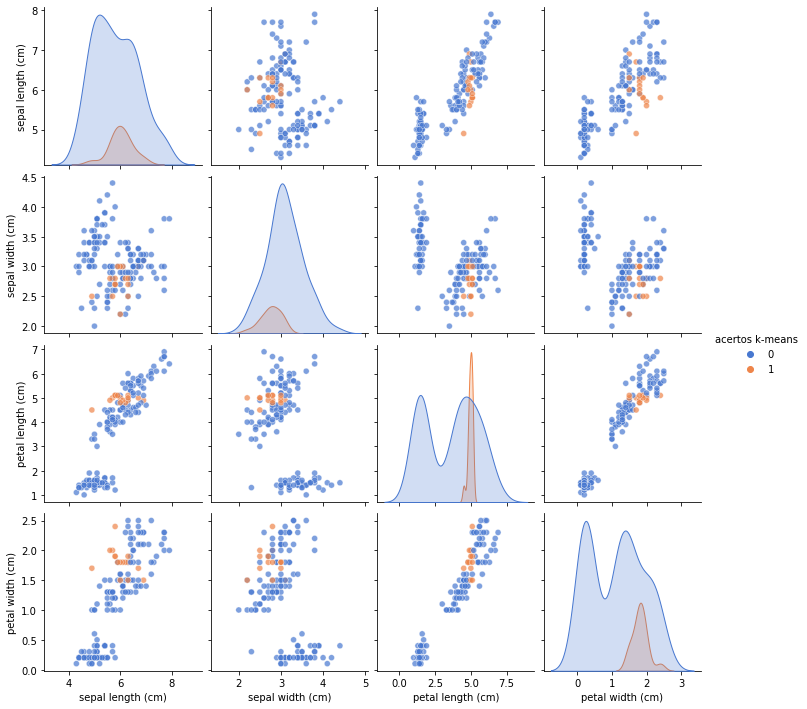

In [148]:
# Acertos k-means
# print(data2)
data2['acertos k-means'] = np.where(data2['k-means']==data2['target'], 0, 1) # 0 = acertos, 1 = erros

# gráfico comparativo dos erros (0 = acertos, 1 = erros)
sns.pairplot(data2.drop(columns=['target', 'k-means', 'k-medoids']), kind="scatter", diag_kind="kde", hue="acertos k-means", palette="muted", plot_kws={'alpha':0.7})
plt.show()

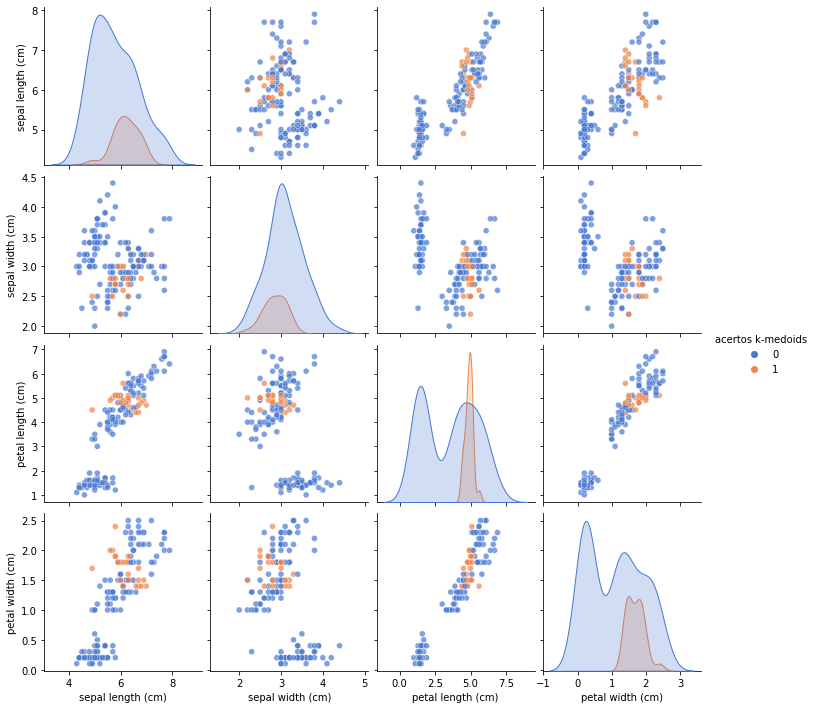

In [149]:
# Acertos k-medoids

# Acertos k-means
# print(data2)
data2['acertos k-medoids'] = np.where(data2['k-medoids']==data2['target'], 0, 1) # 0 = acertos, 1 = erros

# gráfico comparativo dos erros (0 = acertos, 1 = erros)
sns.pairplot(data2.drop(columns=['target', 'k-means', 'k-medoids', 'acertos k-means']), kind="scatter", diag_kind="kde", hue="acertos k-medoids", palette="muted", plot_kws={'alpha':0.7})
plt.show()

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

     target  k-means  k-med

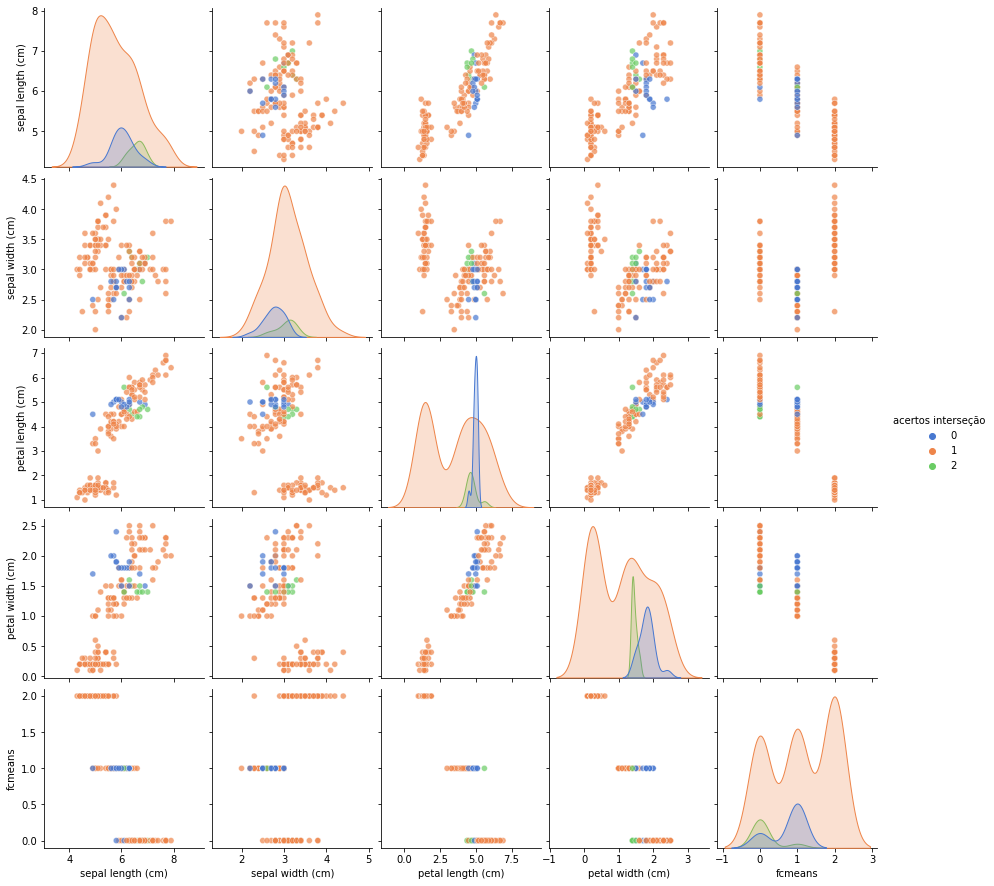

In [156]:
# Interceção dos acertos

# Acertos k-means
# print(data2)
data2['acertos interseção'] = np.where(np.logical_and(data2['acertos k-means']==0, data2['acertos k-medoids']==0), 1, data2['acertos interseção']) # 0 = acertos em comum, 1 = erros
data2['acertos interseção'] = np.where(np.logical_and(data2['acertos k-means']==0, data2['acertos k-medoids']==1), 2, data2['acertos interseção']) # 1 = acertos somente k-means
data2['acertos interseção'] = np.where(np.logical_and(data2['acertos k-means']==1, data2['acertos k-medoids']==0), 3, data2['acertos interseção']) # 1 = acertos somente k-medoids
data2['acertos interseção'] = np.where(np.logical_and(data2['acertos k-means']==1, data2['acertos k-medoids']==1), 0, data2['acertos interseção']) # 1 = erros
# data2['acertos k-medoids'] = np.where(data2['k-medoids']==data2['target'], 0, 1) # 0 = acertos, 1 = erros                                       
print(data2)

# gráfico comparativo dos erros (0 = acertos, 1 = erros)
sns.pairplot(data2.drop(columns=['target', 'k-means', 'k-medoids', 'acertos k-means', 'acertos k-medoids']), kind="scatter", diag_kind="kde", hue="acertos interseção", palette="muted", plot_kws={'alpha':0.7})
plt.show()

---

#### fc-means

O algoritmo *fuzzy c-means* também é da mesma família do *k-means*. A diferença é que, ao invés de usar lógica binária para alocar os elementos a um único *cluster* (*hard clustering*), ele considera que os elementos pertencem a todos os *clusters* ao mesmo tempo (*soft clustering*), mas com graus diferentes de pertinência (i.e., é baseado na lógica *fuzzy*, do inglês "difusa"). 

Para maiores detalhes, leia a [página sobre *Fuzzy Clustering* da Wikipedia](https://en.wikipedia.org/wiki/Fuzzy_clustering).

Segue um exemplo de aplicação desse algoritmo no mesmo conjunto de dados:

In [151]:
# detalhes sobre a biblioteca, seus métodos e parâmetros: https://fuzzy-c-means.readthedocs.io/en/latest/reference/
from fcmeans import FCM

# Vamos fazer uma cópia dos dados anteriores (e manter o resultado do k-means para fins de comparação)
data3 = data2

dados = data3.iloc[:, 0:4] # seleciona só as 4 primeiras colunas
dimensoes = dados.values  # dados vistos como arrays (para usar no kmeans)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(dimensoes)

fcm = FCM(n_clusters=3)
fcm.fit(scaled_features)
data3['fcmeans'] = fcm.predict(scaled_features)
centros = fcm.centers
data3

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,k-means,k-medoids,acertos k-means,acertos k-medoids,acertos interseção,fcmeans
0,5.1,3.5,1.4,0.2,0,0,0,0,0,2,2
1,4.9,3.0,1.4,0.2,0,0,0,0,0,2,2
2,4.7,3.2,1.3,0.2,0,0,0,0,0,2,2
3,4.6,3.1,1.5,0.2,0,0,0,0,0,2,2
4,5.0,3.6,1.4,0.2,0,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,2,2,0,0,2,0
146,6.3,2.5,5.0,1.9,2,1,1,1,1,0,1
147,6.5,3.0,5.2,2.0,2,2,2,0,0,2,0
148,6.2,3.4,5.4,2.3,2,2,2,0,0,2,0


Quando trabalhamos com fc-means, além do `Silhouette`, podemos usar duas métricas específicas para avaliar os resultados: `pc` (*partition coefficient*) e `pec` (*partition entrophy coefficient*). 

O `pc` mede o quão difusa ou próxima da solução *hard* está a solução. Para tanto, a solução *hard* é formada associando cada objeto ao *cluster* ao qual a sua filiação é mais forte. Quanto mais próximo de `0`, mais difuso é o resultado. E quanto mais próximo de `1`, mais `hard`.

Já o `pce` avalia a matriz de pertencimento de cada elemento aos *clusters* (sem considerar os elementos em si). Quanto menores forem os valores, mais nítidas são as partições (i.e., menos difusas). Ela representa a incerteza de uma partição, i.e., a quantidade de informação difusa sobre a filiação de um elemento nas `k` classes.

In [152]:
print(f"pc={fcm.partition_coefficient}")
print(f"pec={fcm.partition_entropy_coefficient}")

pc=0.23550350959632174
pec=0.25459755941251777


---
**Exercício 3**: O código seguinte usa a função `make_moons` para gerar um *dataset* com 2 dimensões e 300 elementos divididos em 2 *clusters*. 

Após, já sabendo que há 2 grupos no conjunto de dados, clusterize os elementos desse *dataset* utilizando os melhores parâmetros e métodos que você aprendeu para os algoritmos `k-means`, `k-medoids` e `fc-means`. Ao final, analise e compare a acurácia, a precisão e a revocação de todos os resultados.

Finalmente, gere um gráfico que distribua os 300 elementos em um espaço 2D, mostrando os conglomerados (*clusters*) originais e, em graficos separados, os conglomerados gerados por cada método de clusterização. Analise o resultado e indique se ele é um conjunto de dados apropriado para algoritmos da família do k-means? Por que? Justifique.

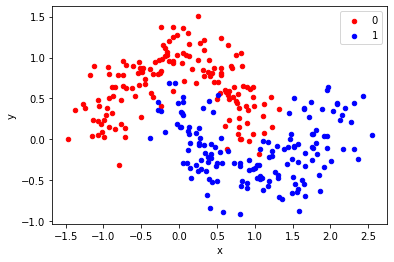

In [160]:
# https://machinelearningmastery.com/generate-test-datasets-python-scikit-learn/
from sklearn.datasets import make_moons

# make_moons sempre cria 2 luas 
features, labels = make_moons(n_samples=300, noise=0.2, random_state=42)

df = pd.DataFrame(dict(x=features[:,0], y=features[:,1], label=labels))

colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

            x         y  label  k-means  k-medoids  fc-means
0    0.803926 -0.291407      1        1          0         1
1    2.314433 -0.122238      1        1          0         1
2   -0.280392  0.450938      1        0          1         0
3    0.789446  0.384060      0        1          0         1
4    1.186657 -0.511438      1        1          0         1
..        ...       ...    ...      ...        ...       ...
295  0.467503 -0.094467      1        1          0         1
296  0.330983  1.209720      0        0          1         0
297 -0.707149  0.914022      0        0          1         0
298  1.513506 -0.085637      1        1          0         1
299 -0.384180  0.863329      0        0          1         0

[300 rows x 6 columns]


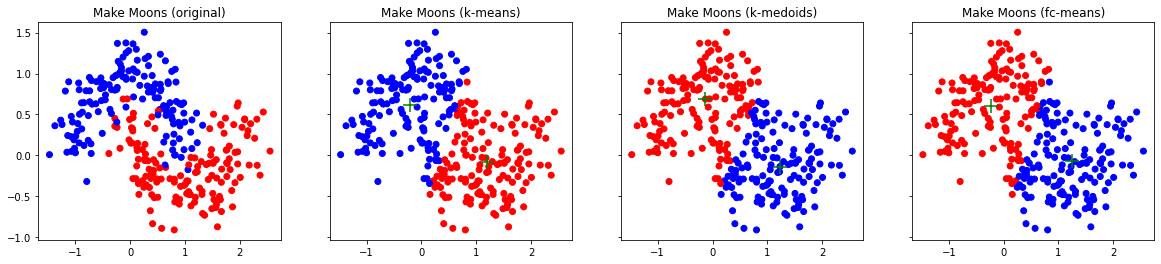

In [167]:
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from fcmeans import FCM
from matplotlib import pyplot 
from sklearn.datasets import make_moons, make_circles, make_classification
from matplotlib import pyplot 
from pandas import DataFrame 

print(df)

km_model = KMeans(n_clusters=2, init="k-means++", n_init=100, max_iter=1000, random_state=0).fit(features)
df['k-means'] = km_model.labels_
df['k-means'].replace((0,1),(1,0),inplace=True)

kmd_model = KMedoids(n_clusters=2, max_iter=1000, random_state=0).fit(features)
df['k-medoids'] = kmd_model.labels_
df['k-medoids'].replace((0,1),(1,0),inplace=True)

fc_model = FCM(n_clusters=2)
fc_model.fit(features)
df['fc-means'] = fc_model.predict(features)
df['fc-means'].replace((0,1),(1,0),inplace=True)

fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(1, 4, sharey=True, figsize=(20,4))
ax1.scatter(df['x'], df['y'], c=df['label'], cmap=pyplot.get_cmap('bwr'))
ax1.set_title("Make Moons (original)")

ax2.scatter(df['x'], df['y'], c=df['k-means'], cmap=pyplot.get_cmap('bwr'))
ax2.scatter(km_model.cluster_centers_[:,0], km_model.cluster_centers_[:,1], c="green", marker="+", s=200)
ax2.set_title("Make Moons (k-means)")

ax3.scatter(df['x'], df['y'], c=df['k-medoids'], cmap=pyplot.get_cmap('bwr'))
ax3.scatter(kmd_model.cluster_centers_[:,0], kmd_model.cluster_centers_[:,1], c="green", marker="+", s=200)
ax3.set_title("Make Moons (k-medoids)")

ax4.scatter(df['x'], df['y'], c=df['fc-means'], cmap=pyplot.get_cmap('bwr'))
ax4.scatter(fc_model.centers[:,0], fc_model.centers[:,1], c="green", marker="+", s=200)
ax4.set_title("Make Moons (fc-means)")

pyplot.show()

**Exercício 3: Tendo em vista a distribuição dos labels originais do problema, nenhum algoritmo da família k-means parece ser ideal para clusterização desse tipo de distribuição.**